In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData)*0.01*TrainingPercent))
    d2 = rawData[:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, TrainingCount): 
    dataMatrix = rawData[TrainingCount:]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, TrainingCount): 
    t =rawData[TrainingCount:]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t


In [3]:
def merge_data_set_feature_concatenation(image_specs, pair_set):
    df3 = pd.merge(pair_set, image_specs ,left_on = "img_id_A", right_on = "img_id",how="inner")
    df4 = pd.merge(df3, image_specs ,left_on = 'img_id_B', right_on = 'img_id',how="inner")
    
    targets = df4['target']

    _RawTarget = targets.values
    datasetStriped = df4.drop(['img_id_A', 'img_id_B', 'target','img_id_x', 'img_id_y'], axis=1)
    
    uniques = datasetStriped.apply(lambda x: x.nunique())
    datasetStriped = datasetStriped.drop(uniques[uniques==1].index, axis=1)
    
    _RawData = datasetStriped.values
    
    return _RawTarget, _RawData

def merge_data_set_feature_subtraction(image_specs, pair_set):
    targets = pair_set['target']
    
    df3 = pd.merge(pair_set, image_specs ,left_on = "img_id_A", right_on = "img_id",how="inner")
    df3 = df3.drop(['img_id_A', 'img_id_B', 'target','img_id'], axis=1)
    

    df4 = pd.merge(pair_set, image_specs ,left_on = 'img_id_B', right_on = 'img_id',how="inner")
    df4 = df4.drop(['img_id_A', 'img_id_B', 'target','img_id'], axis=1)
    
    df5 = df3.sub(df4)
    df5 = df5.abs()
    
    uniques = df5.apply(lambda x: x.nunique())
    df5 = df5.drop(uniques[uniques==1].index, axis=1)
    
    temp_np = df5.values
    

    _RawTarget = targets.values
    _RawData = temp_np
    
    return _RawTarget, _RawData

In [4]:
def generate_training_validation_testing_ds(RawData, RawTarget):
    _TrainingTarget = GenerateTrainingTarget(RawTarget,90)
    _TrainingData   = GenerateTrainingDataMatrix(RawData,90)
    print("Training Target: "+ str(_TrainingTarget.shape))
    print("Training Data: "+ str(_TrainingData.shape))

    _TestDataAct = GenerateValTargetVector(RawTarget, (len(_TrainingTarget)))
    _TestData    = GenerateValData(RawData, (len(_TrainingTarget)))
    print("Testing Target: "+ str(_TestDataAct.shape))
    print("Testing Data: "+ str(_TestData.shape))
    
    return _TrainingTarget, _TrainingData, _TestDataAct, _TestData

## Model Definition

In [5]:
def get_model(input_size, drop_out, dl_1_nodes, dl_2_nodes, dl_3_nodes, opt = 'adam', loss_func = 'binary_crossentropy'):

    
    model = Sequential()
    
    model.add(Dense(dl_1_nodes, input_dim=input_size))
    model.add(Activation('relu'))
  
    model.add(Dropout(drop_out))
    
    model.add(Dense(dl_2_nodes))
    model.add(Activation('relu'))

        
    model.add(Dropout(drop_out))
    
    model.add(Dense(dl_3_nodes))
    model.add(Activation('softmax'))

    
    model.summary()
    
    model.compile(optimizer=opt,
                  loss= loss_func,
                  metrics=['accuracy'])
    
    return model

# Human Observed Data

In [60]:
image_specs_df = pd.read_csv("HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv", index_col=0)

same_pair_df = pd.read_csv("HumanObserved-Dataset/HumanObserved-Features-Data/same_pairs.csv")

diff_pair_df = pd.read_csv("HumanObserved-Dataset/HumanObserved-Features-Data/diffn_pairs.csv")


# create a dataframe by taking a subset from samples of different writers
# Since unmatched dataset is huge we are randomly creating a sample with same data size (791 rows)
# because if the amount of unmatched data overwhelms the matched data, the model may overfit

diff_pair_df_sample = diff_pair_df.sample(n=same_pair_df.shape[0], replace=True)

#Merging same and different writer's data set into one. (1582 rows)
dataset_pairs = pd.concat([diff_pair_df_sample,same_pair_df]).sample(frac=1).reset_index(drop=True)

In [63]:
RawTarget, RawData = merge_data_set_feature_concatenation(image_specs_df, dataset_pairs)
print("=========================")
print("== Human Observed Data ==")
print("==== Concatenation ======")
print("=========================")
print("RawData : " + str(RawData.shape))
print("RawTarget : " + str(RawTarget.shape))

RawTarget, RawData, TestingTarget, TestingData = generate_training_validation_testing_ds(RawData, RawTarget)

model = get_model(RawData.shape[1], 0.2, 512, 256, 2)

validation_data_split = 0.1

num_epochs = 10000  
model_batch_size = 128

tb_batch_size = 32

early_patience = 300

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

TargetVector = np_utils.to_categorical(np.array(RawTarget),2)

# model fit trains the data according to the parameters given to it.
history = model.fit(RawData
                    , TargetVector
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )




== Human Observed Data ==
==== Concatenation ======
RawData : (1582, 18)
RawTarget : (1582,)
Training Target: (1424,)
Training Data: (1424, 18)
Testing Target: (158,)
Testing Data: (158, 18)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 512)               9728      
_________________________________________________________________
activation_31 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_32 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_22 (Dropo

1281/1281 [==============================] - 1s 732us/step - loss: 0.4962 - acc: 0.7471 - val_loss: 0.8749 - val_acc: 0.5035
Epoch 106/10000
1281/1281 [==============================] - 1s 769us/step - loss: 0.5331 - acc: 0.7260 - val_loss: 0.8927 - val_acc: 0.5175
Epoch 107/10000
1281/1281 [==============================] - 1s 703us/step - loss: 0.5251 - acc: 0.7244 - val_loss: 0.8972 - val_acc: 0.4965
Epoch 108/10000
1281/1281 [==============================] - 1s 708us/step - loss: 0.5057 - acc: 0.7486 - val_loss: 0.9290 - val_acc: 0.4406
Epoch 109/10000
1281/1281 [==============================] - 1s 714us/step - loss: 0.5001 - acc: 0.7564 - val_loss: 0.8929 - val_acc: 0.5245
Epoch 110/10000
1281/1281 [==============================] - 1s 858us/step - loss: 0.4732 - acc: 0.7806 - val_loss: 0.9297 - val_acc: 0.4895
Epoch 111/10000
1281/1281 [==============================] - 1s 844us/step - loss: 0.4737 - acc: 0.7658 - val_loss: 0.9478 - val_acc: 0.5035
Epoch 112/10000
1281/1281 [==

1281/1281 [==============================] - 1s 972us/step - loss: 0.3422 - acc: 0.8392 - val_loss: 1.3400 - val_acc: 0.4965
Epoch 222/10000
1281/1281 [==============================] - 2s 1ms/step - loss: 0.3419 - acc: 0.8470 - val_loss: 1.3589 - val_acc: 0.5245
Epoch 223/10000
1281/1281 [==============================] - 1s 981us/step - loss: 0.3299 - acc: 0.8571 - val_loss: 1.3315 - val_acc: 0.4965
Epoch 224/10000
1281/1281 [==============================] - 1s 1ms/step - loss: 0.3028 - acc: 0.8665 - val_loss: 1.4914 - val_acc: 0.4545
Epoch 225/10000
1281/1281 [==============================] - 1s 730us/step - loss: 0.3337 - acc: 0.8470 - val_loss: 1.5035 - val_acc: 0.4755
Epoch 226/10000
1281/1281 [==============================] - 1s 986us/step - loss: 0.3747 - acc: 0.8345 - val_loss: 1.4128 - val_acc: 0.5105
Epoch 227/10000
1281/1281 [==============================] - 1s 751us/step - loss: 0.3602 - acc: 0.8267 - val_loss: 1.4173 - val_acc: 0.5175
Epoch 228/10000
1281/1281 [======

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a43379550>,
      dtype=object)

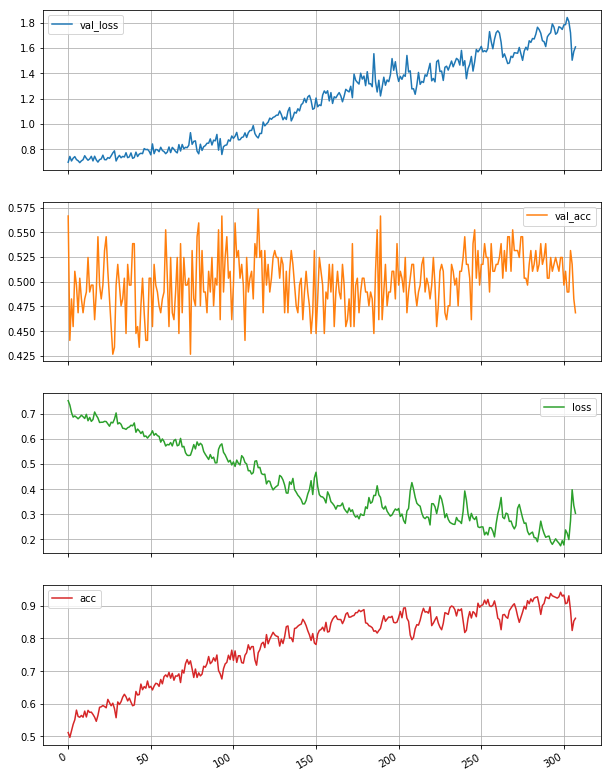

In [64]:
%matplotlib inline

df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [86]:
prediction = model.predict(TestingData)
prediction_classes = prediction.argmax(axis=-1)
score = accuracy_score(TestingTarget, prediction_classes)
print("Accuracy: " + str(score))


Accuracy: 0.4873417721518987


In [87]:
RawTarget, RawData = merge_data_set_feature_subtraction(image_specs_df, dataset_pairs)
print("=========================")
print("== Human Observed Data ==")
print("==== Subtraction ======")
print("=========================")
print("RawData : " + str(RawData.shape))
print("RawTarget : " + str(RawTarget.shape))

RawTarget, RawData, TestingTarget, TestingData = generate_training_validation_testing_ds(RawData, RawTarget)


model = get_model(RawData.shape[1], 0.2, 512, 256, 2)

validation_data_split = 0.2

num_epochs = 10000  
model_batch_size = 128

tb_batch_size = 32

early_patience = 300

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

TargetVector = np_utils.to_categorical(np.array(RawTarget),2)

# model fit trains the data according to the parameters given to it.
history = model.fit(RawData
                    , TargetVector
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )



== Human Observed Data ==
==== Subtraction ======
RawData : (1582, 9)
RawTarget : (1582,)
Training Target: (1424,)
Training Data: (1424, 9)
Testing Target: (158,)
Testing Data: (158, 9)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 512)               5120      
_________________________________________________________________
activation_34 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_35 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_24 (Dropout)  

1139/1139 [==============================] - 1s 653us/step - loss: 0.4235 - acc: 0.7998 - val_loss: 1.1078 - val_acc: 0.4982
Epoch 106/10000
1139/1139 [==============================] - 1s 653us/step - loss: 0.4469 - acc: 0.7875 - val_loss: 1.1036 - val_acc: 0.4842
Epoch 107/10000
1139/1139 [==============================] - 1s 654us/step - loss: 0.4200 - acc: 0.7893 - val_loss: 1.0912 - val_acc: 0.4737
Epoch 108/10000
1139/1139 [==============================] - 1s 654us/step - loss: 0.4275 - acc: 0.7893 - val_loss: 1.0767 - val_acc: 0.4947
Epoch 109/10000
1139/1139 [==============================] - 1s 688us/step - loss: 0.4226 - acc: 0.7989 - val_loss: 1.0982 - val_acc: 0.4842
Epoch 110/10000
1139/1139 [==============================] - 1s 656us/step - loss: 0.4140 - acc: 0.8051 - val_loss: 1.1264 - val_acc: 0.4842
Epoch 111/10000
1139/1139 [==============================] - 1s 657us/step - loss: 0.4098 - acc: 0.7998 - val_loss: 1.1126 - val_acc: 0.4947
Epoch 112/10000
1139/1139 [==

1139/1139 [==============================] - 1s 699us/step - loss: 0.3502 - acc: 0.8095 - val_loss: 1.3648 - val_acc: 0.4947
Epoch 222/10000
1139/1139 [==============================] - 1s 686us/step - loss: 0.3363 - acc: 0.8323 - val_loss: 1.3736 - val_acc: 0.4842
Epoch 223/10000
1139/1139 [==============================] - 1s 689us/step - loss: 0.3366 - acc: 0.8262 - val_loss: 1.3500 - val_acc: 0.4982
Epoch 224/10000
1139/1139 [==============================] - 1s 691us/step - loss: 0.3454 - acc: 0.8183 - val_loss: 1.3434 - val_acc: 0.5088
Epoch 225/10000
1139/1139 [==============================] - 1s 687us/step - loss: 0.3259 - acc: 0.8341 - val_loss: 1.3733 - val_acc: 0.4982
Epoch 226/10000
1139/1139 [==============================] - 1s 689us/step - loss: 0.3380 - acc: 0.8323 - val_loss: 1.4182 - val_acc: 0.4842
Epoch 227/10000
1139/1139 [==============================] - 1s 693us/step - loss: 0.3476 - acc: 0.8218 - val_loss: 1.3844 - val_acc: 0.4982
Epoch 228/10000
1139/1139 [==

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a448e4e10>,
      dtype=object)

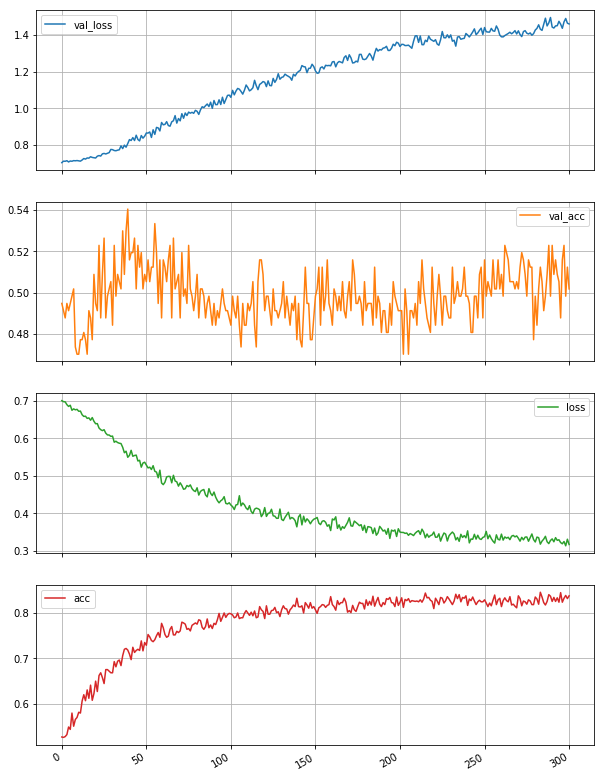

In [88]:
%matplotlib inline

df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [89]:
prediction = model.predict(TestingData)
prediction_classes = prediction.argmax(axis=-1)
score = accuracy_score(TestingTarget, prediction_classes)
print("Accuracy: " + str(score))

Accuracy: 0.4936708860759494


# Gradient Structural Concavity (GSC) Data

In [13]:
image_specs_df = pd.read_csv("GSC-Dataset/GSC-Features-Data/GSC-Features.csv")

same_pair_df = pd.read_csv("GSC-Dataset/GSC-Features-Data/same_pairs.csv")

diff_pair_df = pd.read_csv("GSC-Dataset/GSC-Features-Data/diffn_pairs.csv")


same_pair_df = same_pair_df.sample(n=5000, replace=True)

diff_pair_df_sample = diff_pair_df.sample(n=same_pair_df.shape[0], replace=True)

dataset_pairs = pd.concat([diff_pair_df_sample,same_pair_df]).sample(frac=1).reset_index(drop=True)

In [9]:
RawTarget, RawData = merge_data_set_feature_concatenation(image_specs_df, dataset_pairs)
print("=========================")
print("== Gradient Structural Concavity Data ==")
print("==== Concatenation ======")
print("=========================")
print("RawData : " + str(RawData.shape))
print("RawTarget : " + str(RawTarget.shape))

RawTarget, RawData, TestingTarget, TestingData = generate_training_validation_testing_ds(RawData, RawTarget)


model = get_model(RawData.shape[1], 0.1, 512, 128, 2)

validation_data_split = 0.1

num_epochs = 10000  
model_batch_size = 128

tb_batch_size = 32

early_patience = 100

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

TargetVector = np_utils.to_categorical(np.array(RawTarget),2)

# model fit trains the data according to the parameters given to it.
history = model.fit(RawData
                    , TargetVector
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )



== Gradient Structural Concavity Data ==
==== Concatenation ======
RawData : (10000, 1014)
RawTarget : (10000,)
Training Target: (9000,)
Training Data: (9000, 1014)
Testing Target: (1000,)
Testing Data: (1000, 1014)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 150)               152250    
_________________________________________________________________
activation_4 (Activation)    (None, 150)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               18120     
_________________________________________________________________
activation_5 (Activation)    (None, 120)               0         
__________________________________________________________

8100/8100 [==============================] - 4s 545us/step - loss: 0.0067 - acc: 0.9973 - val_loss: 1.6415 - val_acc: 0.7544
Epoch 48/10000
8100/8100 [==============================] - 4s 548us/step - loss: 0.0052 - acc: 0.9985 - val_loss: 1.7601 - val_acc: 0.7656
Epoch 49/10000
8100/8100 [==============================] - 4s 547us/step - loss: 0.0131 - acc: 0.9960 - val_loss: 1.6140 - val_acc: 0.7700
Epoch 50/10000
8100/8100 [==============================] - 4s 548us/step - loss: 0.0052 - acc: 0.9980 - val_loss: 1.6724 - val_acc: 0.7756
Epoch 51/10000
8100/8100 [==============================] - 4s 555us/step - loss: 0.0174 - acc: 0.9958 - val_loss: 1.6445 - val_acc: 0.7756
Epoch 52/10000
8100/8100 [==============================] - 4s 547us/step - loss: 0.0226 - acc: 0.9943 - val_loss: 1.5649 - val_acc: 0.7844
Epoch 53/10000
8100/8100 [==============================] - 4s 547us/step - loss: 0.0039 - acc: 0.9989 - val_loss: 1.7457 - val_acc: 0.7822
Epoch 54/10000
8100/8100 [=========

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a3c0c3ef0>,
      dtype=object)

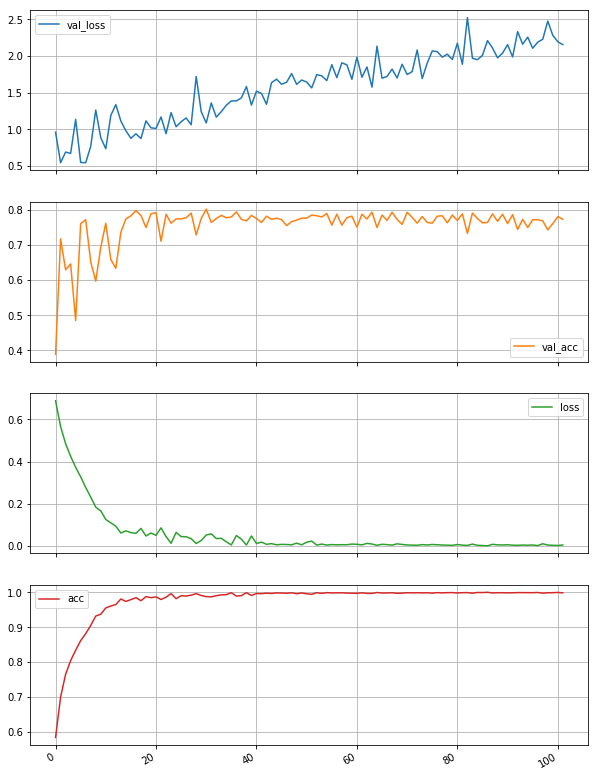

In [10]:
%matplotlib inline

df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [11]:
prediction = model.predict(TestingData)
prediction_classes = prediction.argmax(axis=-1)
score = accuracy_score(TestingTarget, prediction_classes)
print("Accuracy: " + str(score))

Accuracy: 0.729


In [14]:
RawTarget, RawData = merge_data_set_feature_subtraction(image_specs_df, dataset_pairs)
print("=========================")
print("== Gradient Structural Concavity Data ==")
print("==== Subtraction ======")
print("=========================")
print("RawData : " + str(RawData.shape))
print("RawTarget : " + str(RawTarget.shape))

RawTarget, RawData, TestingTarget, TestingData = generate_training_validation_testing_ds(RawData, RawTarget)


model = get_model(RawData.shape[1], 0.1, 150, 120, 2, 'rmsprop', 'categorical_crossentropy')

validation_data_split = 0.1

num_epochs = 10000  
model_batch_size = 100

tb_batch_size = 32

early_patience = 100

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

TargetVector = np_utils.to_categorical(np.array(RawTarget),2)

# model fit trains the data according to the parameters given to it.
history = model.fit(RawData
                    , TargetVector
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )



== Gradient Structural Concavity Data ==
==== Subtraction ======
RawData : (30000, 509)
RawTarget : (30000,)
Training Target: (27000,)
Training Data: (27000, 509)
Testing Target: (3000,)
Testing Data: (3000, 509)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 150)               76500     
_________________________________________________________________
activation_10 (Activation)   (None, 150)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 120)               18120     
_________________________________________________________________
activation_11 (Activation)   (None, 120)               0         
_____________________________________________________________

24300/24300 [==============================] - 9s 377us/step - loss: 0.4769 - acc: 0.7317 - val_loss: 1.0294 - val_acc: 0.5119
Epoch 47/10000
24300/24300 [==============================] - 9s 375us/step - loss: 0.4739 - acc: 0.7359 - val_loss: 0.9697 - val_acc: 0.5026
Epoch 48/10000
24300/24300 [==============================] - 9s 375us/step - loss: 0.4724 - acc: 0.7363 - val_loss: 1.1424 - val_acc: 0.5111
Epoch 49/10000
24300/24300 [==============================] - 9s 375us/step - loss: 0.4714 - acc: 0.7339 - val_loss: 0.9795 - val_acc: 0.5081
Epoch 50/10000
24300/24300 [==============================] - 9s 376us/step - loss: 0.4732 - acc: 0.7339 - val_loss: 1.0167 - val_acc: 0.5007
Epoch 51/10000
24300/24300 [==============================] - 9s 375us/step - loss: 0.4680 - acc: 0.7353 - val_loss: 1.1541 - val_acc: 0.5063
Epoch 52/10000
24300/24300 [==============================] - 9s 376us/step - loss: 0.4718 - acc: 0.7325 - val_loss: 1.0683 - val_acc: 0.5056
Epoch 53/10000
24300/

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a35092940>,
      dtype=object)

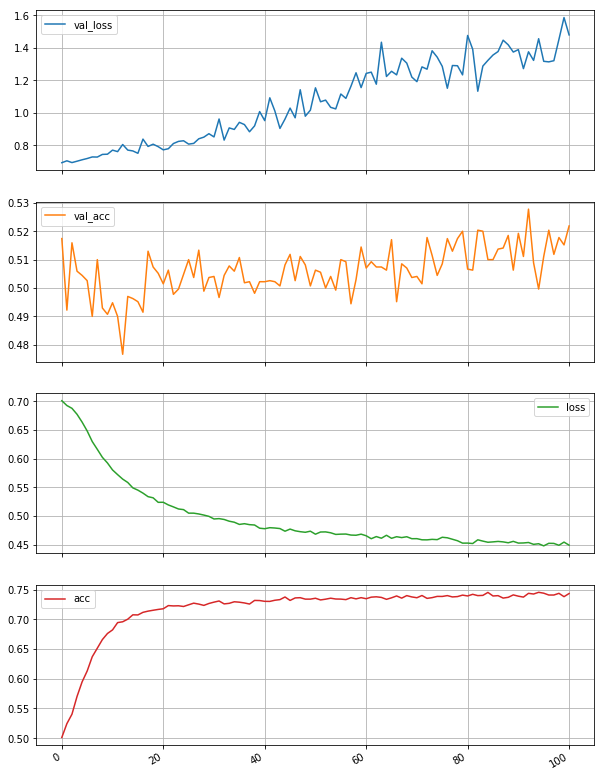

In [15]:
%matplotlib inline

df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [16]:
prediction = model.predict(TestingData)
prediction_classes = prediction.argmax(axis=-1)
score = accuracy_score(TestingTarget, prediction_classes)
print("Accuracy: " + str(score))

Accuracy: 0.494
